In [1]:
%matplotlib inline

In [2]:
#import logging
import os
import random

import numpy as np
import tensorflow as tf

import sys 
sys.path.append(os.path.abspath("/home/himani/learning_to_remember_rare_events"))

import data_utils
import model

import matplotlib.pylab as plt

In [3]:
class flags:
    rep_dim=16 #dimension of keys to use in memory
    episode_length=6 #length of episode 
    episode_width=2 #number of distinct labels in a single episode
    memory_size=None #number of slots in memory
    batch_size=2 #batch size
    num_episodes=5 #number of training episodes
    validation_frequency=1 #every so many training episodes assess validation accuracy
    validation_length=5 #number of episodes to use to compute validation accuracy
    seed=888 #random seed for training sampling
    save_dir='' #directory to save model to
    use_lsh=False #use locality-sensitive hashing (NOTE: not fully tested)
    
FLAGS=flags
random.seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

### Data Exploration

In [4]:
train_data, test_data=data_utils.get_data()

In [5]:
print('Number of train unique classes: %d'%len(train_data))
print('Number of test unique classes: %d'%len(test_data))

Number of train unique classes: 64
Number of test unique classes: 20


In [6]:
#np.random.seed(100)

In [6]:
i=np.random.choice(train_data.keys())
print(i)
j=np.random.choice(test_data.keys())
print(j)

n02927161
n01774750


In [7]:
print('Number of samples per train class: %d'%len(train_data[i]))
print('Number of samples per test class: %d'%len(test_data[j]))

Number of samples per train class: 500
Number of samples per test class: 500


(12288,)
(64, 64, 3)


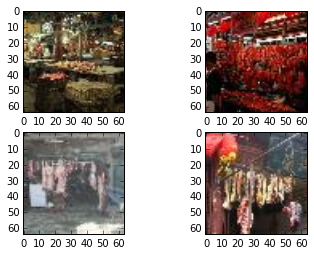

In [8]:
IMAGE_NEW_SIZE = data_utils.IMAGE_NEW_SIZE

for k in range(0,4):
    train_sample=train_data[i][np.random.randint(len(train_data[i]))]
    train_sample_img=np.reshape(train_sample,(IMAGE_NEW_SIZE,IMAGE_NEW_SIZE,-1))
    plt.subplot(2, 2, k+1)
    plt.imshow(train_sample_img,cmap='gray')

print(train_sample.shape)
print(train_sample_img.shape)

In [9]:
28/4

7

In [10]:
64/16

4

### Training code

Fetch data

In [4]:
train_data, valid_data = data_utils.get_data()

train_size = len(train_data)
valid_size = len(valid_data)

print(type(train_data))
print('train_size (number of labels) %d'%(train_size))
print('valid_size (number of labels) %d'%(valid_size))

<type 'dict'>
train_size (number of labels) 64
valid_size (number of labels) 20


Initialize variables for training, validating, and checkpointing model.

In [5]:
input_dim = data_utils.IMAGE_NEW_SIZE ** 2
input_channel=data_utils.IMAGE_CHANNEL
output_dim=None
rep_dim = FLAGS.rep_dim
episode_length = FLAGS.episode_length
episode_width = FLAGS.episode_width
batch_size = FLAGS.batch_size
memory_size = (episode_length * batch_size if FLAGS.memory_size is None 
               else FLAGS.memory_size)
use_lsh = FLAGS.use_lsh
output_dim = (output_dim if output_dim is not None 
              else episode_width)
#output_dim = episode_width

assert all(len(v) >= float(episode_length) / episode_width
            for v in train_data.itervalues())
assert all(len(v) >= float(episode_length) / episode_width
            for v in valid_data.itervalues())

print('input_dim %d'%(input_dim))
print('input_channel %d'%(input_channel))
print('output_dim %d'%(output_dim))
print('rep_dim %d'%(rep_dim))
print('episode_length %d'%(episode_length))
print('episode_width %d'%(episode_width))
print('memory_size %d'%(memory_size))
print('batch_size %d'%(batch_size))

input_dim 4096
input_channel 3
output_dim 2
rep_dim 16
episode_length 6
episode_width 2
memory_size 12
batch_size 2


Create utility functions

In [6]:
def get_model():
    # vocab size is the number of distinct values that
    # could go into the memory key-value storage
    vocab_size = episode_width * batch_size
    return model.Model(
        input_dim, input_channel, output_dim, rep_dim, memory_size,
        vocab_size, use_lsh=use_lsh)

def compute_correct(ys, y_preds):
    return np.mean(np.equal(y_preds, np.array(ys)))

def individual_compute_correct(y, y_pred):
    return y_pred == y

def sample_episode_batch(data,episode_length, episode_width, batch_size):
    """Generates a random batch for training or validation.

    Structures each element of the batch as an 'episode'.
    Each episode contains episode_length examples and
    episode_width distinct labels.

    Args:
      data: A dictionary mapping label to list of examples.
      episode_length: Number of examples in each episode.
      episode_width: Distinct number of labels in each episode.
      batch_size: Batch size (number of episodes).

    Returns:
      A tuple (x, y) where x is a list of batches of examples
      with size episode_length and y is a list of batches of labels.
    """
    episodes_x = [[] for _ in xrange(episode_length)]
    episodes_y = [[] for _ in xrange(episode_length)]
    assert len(data) >= episode_width
    keys = data.keys()
    for b in xrange(batch_size):
        episode_labels = random.sample(keys, episode_width)
        remainder = episode_length % episode_width
        remainders = [0] * (episode_width - remainder) + [1] * remainder
        episode_x = [random.sample(data[lab],
                    r + (episode_length - remainder) / episode_width)
                    for lab, r in zip(episode_labels, remainders)]
        episode = sum([[(x, i, ii) for ii, x in enumerate(xx)]
                for i, xx in enumerate(episode_x)], [])
        random.shuffle(episode)
        # Arrange episode so that each distinct label is seen before moving to
        # 2nd showing
        episode.sort(key=lambda elem: elem[2])
        assert len(episode) == episode_length
        for i in xrange(episode_length):
            episodes_x[i].append(episode[i][0])
            episodes_y[i].append(episode[i][1] + b * episode_width)

    return ([np.array(xx).astype('float32') for xx in episodes_x],
            [np.array(yy).astype('int32') for yy in episodes_y])

Initialize session and model 

In [7]:
print('Creating model')
model = get_model()
model.setup()

print('Starting session')
config=tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())

ckpt = None
if FLAGS.save_dir:
    ckpt = tf.train.get_checkpoint_state(FLAGS.save_dir)
if ckpt and ckpt.model_checkpoint_path:
    print('restoring from %s'%(ckpt.model_checkpoint_path))
    saver.restore(sess, ckpt.model_checkpoint_path)

Creating model
Starting session


Perform episodic training and validation

In [11]:
x[0].shape

(2, 12288)

In [8]:
print('starting now')
losses = []
random.seed(FLAGS.seed)
np.random.seed(FLAGS.seed)
for i in xrange(FLAGS.num_episodes):
    x, y = sample_episode_batch(
    train_data, episode_length, episode_width, batch_size)
    outputs = model.episode_step(sess, x, y, clear_memory=True)
    loss = outputs
    losses.append(loss)
    
    if i % FLAGS.validation_frequency == 0:
        print('\nepisode batch %d, avg train loss %f'%(i, np.mean(losses)))
        losses = []

        # validation
        correct = []
        correct_by_shot = dict((k, []) for k in xrange(episode_width + 1))
        for _ in xrange(FLAGS.validation_length):
            x, y = sample_episode_batch(
                valid_data, episode_length, episode_width, 1)
            outputs = model.episode_predict(sess, x, y, clear_memory=True)
            y_preds = outputs
            correct.append(compute_correct(np.array(y), y_preds))

        # compute per-shot accuracies
        seen_counts = [[0] * episode_width for _ in xrange(batch_size)]
        # loop over episode steps
        for yy, yy_preds in zip(y, y_preds):
        # loop over batch examples
            for k, (yyy, yyy_preds) in enumerate(zip(yy, yy_preds)):
                yyy, yyy_preds = int(yyy), int(yyy_preds)
                count = seen_counts[k][yyy % episode_width]
                if count in correct_by_shot:
                    correct_by_shot[count].append(
                        individual_compute_correct(yyy, yyy_preds))
                seen_counts[k][yyy % episode_width] = count + 1

        print('validation overall accuracy %f'%(np.mean(correct)))
        print_list=sum([[k, np.mean(correct_by_shot[k])]
                        for k in xrange(episode_width + 1)], [])
        print_str=''
        xx=0
        while xx < (len(print_list)):
            print_str=print_str+('%d-shot: %.3f, '%(print_list[xx],print_list[xx+1]))
            xx+=2
        print(print_str)

starting now

episode batch 0, avg train loss 0.251557
validation overall accuracy 0.466667
0-shot: 0.000, 1-shot: 0.500, 2-shot: 0.000, 

episode batch 1, avg train loss 0.263777
validation overall accuracy 0.533333
0-shot: 0.000, 1-shot: 0.500, 2-shot: 1.000, 

episode batch 2, avg train loss 0.201594
validation overall accuracy 0.400000
0-shot: 0.000, 1-shot: 1.000, 2-shot: 0.500, 

episode batch 3, avg train loss 0.468237
validation overall accuracy 0.333333
0-shot: 0.500, 1-shot: 0.500, 2-shot: 0.000, 

episode batch 4, avg train loss 0.217961
validation overall accuracy 0.400000
0-shot: 0.500, 1-shot: 0.500, 2-shot: 0.500, 


### Episode check

In [7]:
def sample_episode_batch_aug(data,episode_length, episode_width, batch_size):
    """Generates a random batch for training or validation.

    Structures each element of the batch as an 'episode'.
    Each episode contains episode_length examples and
    episode_width distinct labels.

    Args:
      data: A dictionary mapping label to list of examples.
      episode_length: Number of examples in each episode.
      episode_width: Distinct number of labels in each episode.
      batch_size: Batch size (number of episodes).

    Returns:
      A tuple (x, y) where x is a list of batches of examples
      with size episode_length and y is a list of batches of labels.
    """
    episodes_x = [[] for _ in xrange(episode_length)]
    episodes_y = [[] for _ in xrange(episode_length)]
    assert len(data) >= episode_width
    keys = data.keys()
    for b in xrange(batch_size):
        episode_labels = random.sample(keys, episode_width)
        remainder = episode_length % episode_width
        remainders = [0] * (episode_width - remainder) + [1] * remainder
        episode_x = [random.sample(data[lab],
                    r + (episode_length - remainder) / episode_width)
                    for lab, r in zip(episode_labels, remainders)]
        episode = sum([[(x, i, ii) for ii, x in enumerate(xx)]
                for i, xx in enumerate(episode_x)], [])
        random.shuffle(episode)
        # Arrange episode so that each distinct label is seen before moving to
        # 2nd showing
        episode.sort(key=lambda elem: elem[2])
        assert len(episode) == episode_length
        for i in xrange(episode_length):
            episodes_x[i].append(episode[i][0])
            episodes_y[i].append(episode[i][1] + b * episode_width)

    return ([np.array(xx).astype('float32') for xx in episodes_x],
            [np.array(yy).astype('int32') for yy in episodes_y])

In [8]:
x, y = sample_episode_batch_aug(train_data, episode_length, episode_width, batch_size)

In [9]:
print(type(x))
print(len(x)) #number of episodes 
print(x[0].shape) #batch size, flattened image
print(y[0].shape) #batch size (labels)

<type 'list'>
6
(2, 12288)
(2,)


In [101]:
img=x[0][0,:]
print(img.shape)
print(type(img))
print(img.dtype)

(12288,)
<type 'numpy.ndarray'>
float32


In [102]:
img_reshape=np.reshape(img,(data_utils.IMAGE_NEW_SIZE,data_utils.IMAGE_NEW_SIZE,data_utils.IMAGE_CHANNEL))
img_reshape=np.asarray(img_reshape,dtype='uint8')

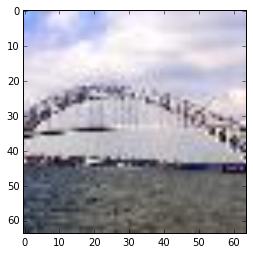

In [103]:
plt.imshow(img_reshape)

In [23]:
len(train_data)

64

In [42]:
print(train_data.keys())

['n02823428', 'n07579787', 'n09246464', 'n02124075', 'n04067472', 'n04311004', 'n02808440', 'n02123394', 'n03085013', 'n02423022', 'n04465501', 'n01629819', 'n04265275', 'n02233338', 'n02963159', 'n02231487', 'n07734744', 'n03670208', 'n03250847', 'n03902125', 'n02099601', 'n03854065', 'n03599486', 'n03837869', 'n02883205', 'n04417672', 'n09193705', 'n04562935', 'n07875152', 'n01944390', 'n09256479', 'n02837789', 'n02106662', 'n03814639', 'n04540053', 'n04399382', 'n04456115', 'n04532670', 'n02666196', 'n02948072', 'n04275548', 'n02791270', 'n03400231', 'n04285008', 'n02321529', 'n01855672', 'n03160309', 'n07711569', 'n03179701', 'n07695742', 'n02113799', 'n03977966', 'n04507155', 'n03617480', 'n02788148', 'n03662601', 'n04596742', 'n01644900', 'n03992509', 'n04501370', 'n01770393', 'n03838899', 'n02927161', 'n02841315']


In [27]:
len(train_data['n02823428'])

500

In [86]:
img=train_data['n02231487'][56]
print(img.shape)
print(type(img))
print(img.dtype)
img_reshape=np.reshape(img,(data_utils.IMAGE_NEW_SIZE,data_utils.IMAGE_NEW_SIZE,data_utils.IMAGE_CHANNEL))

(12288,)
<type 'numpy.ndarray'>
uint8


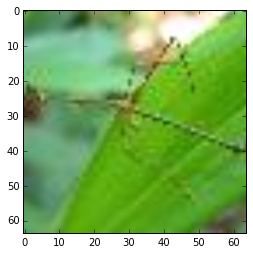

In [73]:
plt.imshow(img_reshape)

In [56]:
for ep in y:
    print ep

[ 1  9 14 18 24 27 30 37 44 47 50 57 62 65 70 76]
[ 0  8 10 19 20 29 34 35 41 45 54 56 60 66 73 75]
[ 3  7 12 16 22 25 33 39 42 48 53 59 63 69 74 79]
[ 4  6 13 15 21 26 32 38 40 49 51 58 64 68 72 78]
[ 2  5 11 17 23 28 31 36 43 46 52 55 61 67 71 77]
[ 0  9 10 17 23 26 33 39 42 48 53 57 63 69 70 77]
[ 4  5 11 18 20 29 32 38 44 45 52 56 60 67 72 75]
[ 3  8 13 19 21 25 30 37 40 49 50 55 64 66 74 79]
[ 1  6 12 15 22 28 31 36 43 46 54 58 62 65 73 76]
[ 2  7 14 16 24 27 34 35 41 47 51 59 61 68 71 78]
[ 3  9 10 15 22 26 34 38 43 49 50 59 63 66 70 75]
[ 1  5 11 18 21 29 30 36 44 45 54 57 60 67 73 79]
[ 0  6 14 19 24 25 33 39 41 48 52 55 61 68 72 76]
[ 4  7 13 16 23 27 32 35 42 47 51 58 64 69 71 77]
[ 2  8 12 17 20 28 31 37 40 46 53 56 62 65 74 78]
[ 1  8 11 17 23 29 32 37 43 45 50 57 60 66 74 77]
[ 2  6 12 16 24 26 34 36 41 46 51 56 64 67 73 76]
[ 0  9 14 15 21 25 31 38 42 49 52 58 61 68 70 79]
[ 3  5 13 18 20 27 33 39 40 47 54 55 63 65 72 75]
[ 4  7 10 19 22 28 30 35 44 48 53 59 62 69 71 78]


()


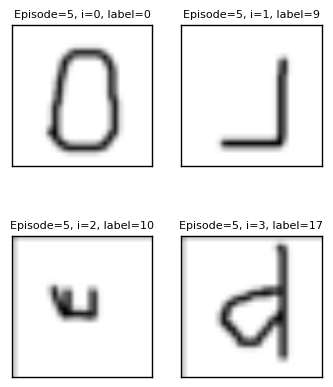

In [57]:
IMAGE_NEW_SIZE = data_utils.IMAGE_NEW_SIZE
fig=plt.figure(figsize=(4,5))

episode_num=5#np.random.choice(episode_length)
print()
for k in range(0,4):
    
    i=k#np.random.choice(batch_size)

    sample_img=x[episode_num][i]
    sample_img=np.reshape(sample_img,(IMAGE_NEW_SIZE,IMAGE_NEW_SIZE))
    plt.subplot(2, 2, k+1)
    plt.imshow(sample_img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Episode=%d, i=%d, label=%d'%(episode_num,i,y[episode_num][i]),fontsize=8)

Sample Episode creation

In [14]:
data=train_data
episode_length=10
episode_width=2
batch_size=1

In [73]:
episodes_x = [[] for _ in xrange(episode_length)]
episodes_y = [[] for _ in xrange(episode_length)]
assert len(data) >= episode_width
keys = data.keys()
print(len(episodes_x))
print(len(keys))

10
3856


In [21]:
random.seed(100)

#randomly sample labels (episode width size)
episode_labels = random.sample(keys, episode_width)

#number of samples per label=int(episode_length/episode_width) + remainder
remainder = episode_length % episode_width
remainders = [0] * (episode_width - remainder) + [1] * remainder

print(episode_labels)
print(remainder)
print(remainders)

[561, 1754]
0
[0, 0]


In [38]:
#randomly sample data sample for each label 
episode_x = [random.sample(data[lab],
             r + (episode_length - remainder) / episode_width)
             for lab, r in zip(episode_labels, remainders)]

print(zip(episode_labels, remainders))
print(len(episode_x)) #number of labels
print(len(episode_x[0])) #number of samples for 1 label 
print(episode_x[0][0].shape)

[(561, 0), (1754, 0)]
2
5
(784,)


In [52]:
for i, xx in enumerate(episode_x):
    for ii, x in enumerate(xx):
        print('i=%d, ii=%d'%(i,ii))
        print(len(xx))
        #print(x.shape)    

i=0, ii=0
5
i=0, ii=1
5
i=0, ii=2
5
i=0, ii=3
5
i=0, ii=4
5
i=1, ii=0
5
i=1, ii=1
5
i=1, ii=2
5
i=1, ii=3
5
i=1, ii=4
5


In [71]:
#create tuple for data_sample, label, sample_id (for rearranging)
episode = sum([[(x, i, ii) for ii, x in enumerate(xx)]
               for i, xx in enumerate(episode_x)], [])
print(len(episode))
print(type(episode[0]))
print(len(episode[0]))

for f in range(len(episode)):
    print('data shape: %d, label: %d, sample: %d'
          %(episode[f][0].shape[0],episode[f][1],episode[f][2]))

10
<type 'tuple'>
3
data shape: 784, label: 0, sample: 0
data shape: 784, label: 0, sample: 1
data shape: 784, label: 0, sample: 2
data shape: 784, label: 0, sample: 3
data shape: 784, label: 0, sample: 4
data shape: 784, label: 1, sample: 0
data shape: 784, label: 1, sample: 1
data shape: 784, label: 1, sample: 2
data shape: 784, label: 1, sample: 3
data shape: 784, label: 1, sample: 4


In [72]:
random.shuffle(episode)
# Arrange episode so that each distinct label is seen before moving to
# 2nd showing
episode.sort(key=lambda elem: elem[2])

for f in range(len(episode)):
    print('data shape: %d, label: %d, sample: %d'
          %(episode[f][0].shape[0],episode[f][1],episode[f][2]))

data shape: 784, label: 0, sample: 0
data shape: 784, label: 1, sample: 0
data shape: 784, label: 1, sample: 1
data shape: 784, label: 0, sample: 1
data shape: 784, label: 0, sample: 2
data shape: 784, label: 1, sample: 2
data shape: 784, label: 0, sample: 3
data shape: 784, label: 1, sample: 3
data shape: 784, label: 1, sample: 4
data shape: 784, label: 0, sample: 4


In [79]:
#append samples and labels batch-wise 

b=0 #batch number
assert len(episode) == episode_length
for i in xrange(episode_length):
    episodes_x[i].append(episode[i][0]) #sample data
    episodes_y[i].append(episode[i][1] + b * episode_width) 
    
print(episodes_y)
print(len(episodes_y)) #number of episodes
print(len(episodes_y[0])) #number of batches

[[0], [1], [1], [0], [0], [1], [0], [1], [1], [0]]
10
1


In [81]:
#return tuple of sample points and labels in an episode (batch-wise)
sample_ep=([np.array(xx).astype('float32') for xx in episodes_x],
    [np.array(yy).astype('int32') for yy in episodes_y])

### Memory check

In [43]:
print('starting now')
losses = []

max_iter=FLAGS.num_episodes
max_iter=1

for i in xrange(max_iter):
    x, y = sample_episode_batch(train_data, episode_length, episode_width, batch_size)
    
    #outputs = model.episode_step(sess, x, y, clear_memory=True)
    #loss = outputs #sample-wise loss
    
    outputs = [model.loss, model.gradient_ops, model.memory.get()]
    clear_memory=True
    if clear_memory:
        model.clear_memory(sess)
    #out = sess.run([model.memory.get()])
    #break
        
    loss = []
    for xx, yy in zip(x, y):
        out = sess.run(outputs, feed_dict={model.x: xx, model.y: yy})
        loss.append(out[0])
        
        mem_out=out[2]
        mem_keys, mem_vals, mem_age, recent_idx = mem_out
        
        print('loss: %f'%(out[0]))
        print('y: %s'%(yy))
        print('mem_vals: %s'%(mem_vals)) 
        print('mem_age: %s'%(mem_age))
        print('recent_idx: %s'%(recent_idx))
        print('\n')
    
    losses.append(loss)
    print('iter: %d, loss: %s'%(i,loss))

starting now
loss: 0.000000
y: [1 2]
mem_vals: [0 1 0 0 0 0 0 0 2 0 0 0]
mem_age: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
recent_idx: [0 1 8 0]


loss: 0.464177
y: [0 3]
mem_vals: [0 1 3 0 0 0 0 0 2 0 0 0]
mem_age: [ 2.  1.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.]
recent_idx: [3 1 8 2]


loss: 0.735076
y: [0 2]
mem_vals: [0 1 3 0 0 0 0 0 2 0 2 0]
mem_age: [ 2.  1.  0.  0.  2.  2.  2.  2.  1.  2.  2.  2.]
recent_idx: [ 9  1 10  2]


loss: 0.217053
y: [1 3]
mem_vals: [0 3 3 0 0 0 0 0 2 0 2 1]
mem_age: [ 3.  2.  1.  1.  3.  3.  3.  3.  2.  0.  0.  3.]
recent_idx: [ 9 11 10  1]


loss: 0.040230
y: [0 3]
mem_vals: [0 3 3 0 0 0 0 0 2 0 2 1]
mem_age: [ 4.  0.  2.  2.  4.  4.  4.  4.  3.  1.  1.  0.]
recent_idx: [ 4 11 10  1]


loss: -0.001252
y: [1 2]
mem_vals: [0 3 2 0 0 0 0 0 2 0 2 1]
mem_age: [ 6.  1.  4.  4.  1.  6.  6.  6.  5.  3.  3.  2.]
recent_idx: [ 4 11  2  1]


iter: 0, loss: [0.0, 0.46417701, 0.73507583, 0.2170534, 0.040230498, -0.0012515709]


In [21]:
len(out)

3

In [22]:
out[0]

0.52287066

In [23]:
out[1]

In [27]:
mem_out=out[2]
mem_keys, mem_vals, mem_age, recent_idx = mem_out

In [29]:
len(mem_keys)

12

In [30]:
mem_vals

array([3, 2, 0, 1, 3, 0, 0, 0, 0, 2, 0, 2], dtype=int32)

In [31]:
y

[array([1, 3], dtype=int32),
 array([0, 2], dtype=int32),
 array([0, 3], dtype=int32),
 array([1, 2], dtype=int32),
 array([0, 2], dtype=int32),
 array([1, 3], dtype=int32)]

In [32]:
mem_age

array([ 3.,  3.,  5.,  5.,  2.,  5.,  5.,  5.,  5.,  0.,  0.,  1.], dtype=float32)

In [33]:
recent_idx

array([10,  3,  9,  0], dtype=int32)

In [36]:
mem_init=out[0]
mem_keys, mem_vals, mem_age, recent_idx = mem_init

In [40]:
recent_idx

array([0, 0, 0, 0], dtype=int32)

### Validation check

In [11]:
print('starting now')
losses = []
random.seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

max_iter=FLAGS.num_episodes
max_iter=1

for i in xrange(max_iter):
    x, y = sample_episode_batch(
    train_data, episode_length, episode_width, batch_size)
    outputs = model.episode_step(sess, x, y, clear_memory=True)
    loss = outputs
    losses.append(loss)
    
    print('\nepisode batch %d, avg train loss %f'%(i, np.mean(losses)))

starting now

episode batch 0, avg train loss 0.279205


Per-shot accuracies

In [12]:
shot_width=int(episode_length/episode_width*1.0)-1
print(shot_width)

5


In [13]:
losses = []
correct = []
correct_by_shot = dict((k, []) for k in xrange(shot_width + 1))
print(correct_by_shot)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: []}


In [14]:
x, y = sample_episode_batch( 
    valid_data, episode_length, episode_width, 1) #batch_size=1

outputs = model.episode_predict(sess, x, y, clear_memory=True)
y_preds = outputs
correct.append(compute_correct(np.array(y), y_preds))

In [15]:
y

[array([1], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([1], dtype=int32)]

In [16]:
y_preds

[array([0], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([2], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32)]

In [17]:
#how many examples seen per label
seen_counts = [0] * episode_width 
print(seen_counts)

[0, 0, 0]


In [18]:
# loop over episode steps
for yy, yy_preds in zip(y, y_preds):
    # loop over batch examples
    #print('Loop 1: yy=%s,yy_preds=%s'%(yy,yy_preds))
    for (yyy, yyy_preds) in zip(yy, yy_preds):
        
    
        yyy, yyy_preds = int(yyy), int(yyy_preds)
        print('\nLoop 2: yyy=%d,yyy_preds=%d'%(yyy,yyy_preds))
        
        #encoded label number
        print('New label: %d'%(yyy % episode_width))  
        #how many examples seen per label
        print('seen_counts: %s'%(seen_counts))
        
        #how many examples seen so far for this one 
        count = seen_counts[yyy % episode_width] 
        print('this_shot: %d'%(count))
        if count in correct_by_shot:
            correct_by_shot[count].append(
                individual_compute_correct(yyy, yyy_preds))
        else:
            print('Shot not found!!')
            break
        seen_counts[yyy % episode_width] = count + 1
        print('correct_by_shot: %s'%(correct_by_shot))


Loop 2: yyy=1,yyy_preds=0
New label: 1
seen_counts: [0, 0, 0]
this_shot: 0
correct_by_shot: {0: [False], 1: [], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=2,yyy_preds=1
New label: 2
seen_counts: [0, 1, 0]
this_shot: 0
correct_by_shot: {0: [False, False], 1: [], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=0,yyy_preds=1
New label: 0
seen_counts: [0, 1, 1]
this_shot: 0
correct_by_shot: {0: [False, False, False], 1: [], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=0,yyy_preds=2
New label: 0
seen_counts: [1, 1, 1]
this_shot: 1
correct_by_shot: {0: [False, False, False], 1: [False], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=2,yyy_preds=0
New label: 2
seen_counts: [2, 1, 1]
this_shot: 1
correct_by_shot: {0: [False, False, False], 1: [False, False], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=1,yyy_preds=1
New label: 1
seen_counts: [2, 1, 2]
this_shot: 1
correct_by_shot: {0: [False, False, False], 1: [False, False, True], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=1,yyy_preds=1
New label: 1
seen_counts: [2,

In [19]:
correct #averaged over validation_length 
print('validation overall accuracy %f'%(np.mean(correct)))

validation overall accuracy 0.222222


In [20]:
print(correct_by_shot)
print_list=sum([[k, np.mean(correct_by_shot[k])]
                        for k in xrange(shot_width + 1)], [])
print(print_list)

{0: [False, False, False], 1: [False, False, True], 2: [True, False, False], 3: [True, False, False], 4: [False, True, False], 5: [False, False, False]}
[0, 0.0, 1, 0.33333333333333331, 2, 0.33333333333333331, 3, 0.33333333333333331]


In [21]:
print_str=''
xx=0
while xx < (len(print_list)):
    print_str=print_str+('%d-shot: %.3f, '%(print_list[xx],print_list[xx+1]))
    xx+=2
print(print_str)

0-shot: 0.000, 1-shot: 0.333, 2-shot: 0.333, 3-shot: 0.333, 
